In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy.signal import butter, filtfilt, iirnotch, stft, welch


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tqdm import tqdm

In [2]:
fs_signals = 1000
fs_force = 100

In [3]:
mat = scipy.io.loadmat('../Dataset/Dataset_isometric_task.mat')
D   = mat['Dataset'][0,0]
force_cells  = D['force']['signals'][0,0]
force_fs     = int(D['force']['fc_Hz'][0,0])

C:\Users\cribr\AppData\Local\Temp\ipykernel_5340\2255911572.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  force_fs     = int(D['force']['fc_Hz'][0,0])


In [4]:
muscle = D['muscle']
muscle_fields = list(muscle.dtype.names[:-1])

emg_cells = {mus: D['muscle'][mus][0,0] for mus in muscle_fields}
emg_fs = int(D['muscle']['fc_Hz'][0,0])

C:\Users\cribr\AppData\Local\Temp\ipykernel_10108\4061884539.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  emg_fs = int(D['muscle']['fc_Hz'][0,0])


In [5]:
data = []

for direction in range(12):
    data.append([])
    for repetition in range(4):
        muscle_dict = {}
        for muscle_type in muscle_fields:
            muscle_dict[muscle_type] = emg_cells[muscle_type][direction][repetition].ravel()
            
        muscle_dict["force_x"] = force_cells[direction][repetition][:, 0]
        muscle_dict["force_y"] = force_cells[direction][repetition][:, 1]
        muscle_dict["force_magnitude"] = (muscle_dict["force_x"]**2 + muscle_dict['force_y']**2)**0.5
        muscle_dict["direction"] = direction
        muscle_dict["repetition"] = repetition
        data[-1].append(muscle_dict)

In [6]:
len(data), len(data[0])

(12, 4)

In [7]:
single_trial = data[0][0]

In [8]:
muscle_fields

['aDEL', 'pDEL', 'lBIC', 'sBIC', 'lTRI', 'sTRI', 'BRA', 'mPEC']

In [9]:
muscle_fields = np.setdiff1d(muscle_fields,["sTRI"]).tolist()
muscle_fields

['BRA', 'aDEL', 'lBIC', 'lTRI', 'mPEC', 'pDEL', 'sBIC']

In [10]:
for i in range(12):
    for j in range(4):
        curr_dict = data[i][j]
        data[i][j] = {k: curr_dict[k] for k in curr_dict.keys() if k!="sTRI"}
print(data[i][j].keys())

dict_keys(['aDEL', 'pDEL', 'lBIC', 'sBIC', 'lTRI', 'BRA', 'mPEC', 'force_x', 'force_y', 'force_magnitude', 'direction', 'repetition'])


In this section we want to known if Independent Component Analysis (ICA) may improve our performances with respect
to the raw signal regressor. We do this because we want to reduce the effects of Cross-Talk as shown in https://pubmed.ncbi.nlm.nih.gov/17405383/ . Our case we dont have HD-EMG but it may benefits from ICA

In [11]:
from sklearn.decomposition import FastICA


X = [single_trial[x] for x in muscle_fields]
X = np.array(X)

ica = FastICA(n_components=len(muscle_fields))
S_ = ica.fit_transform(X.T)

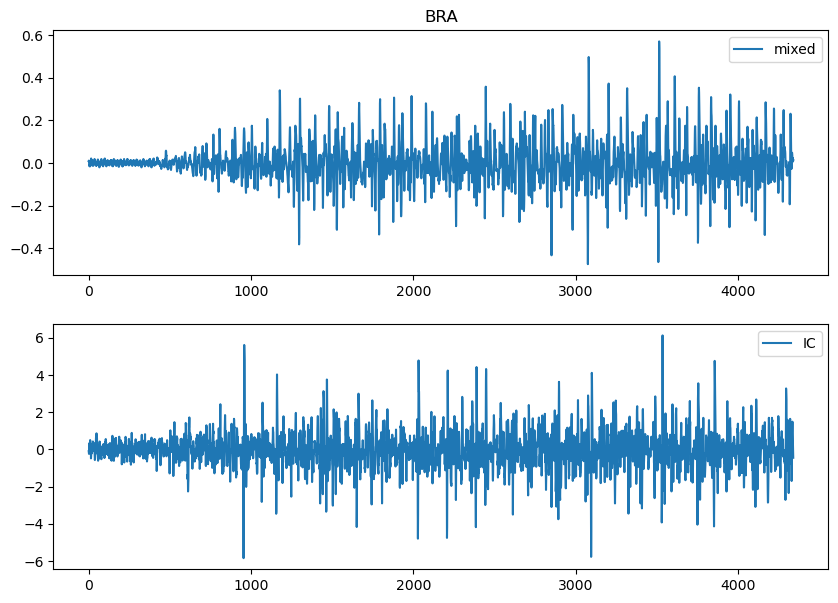

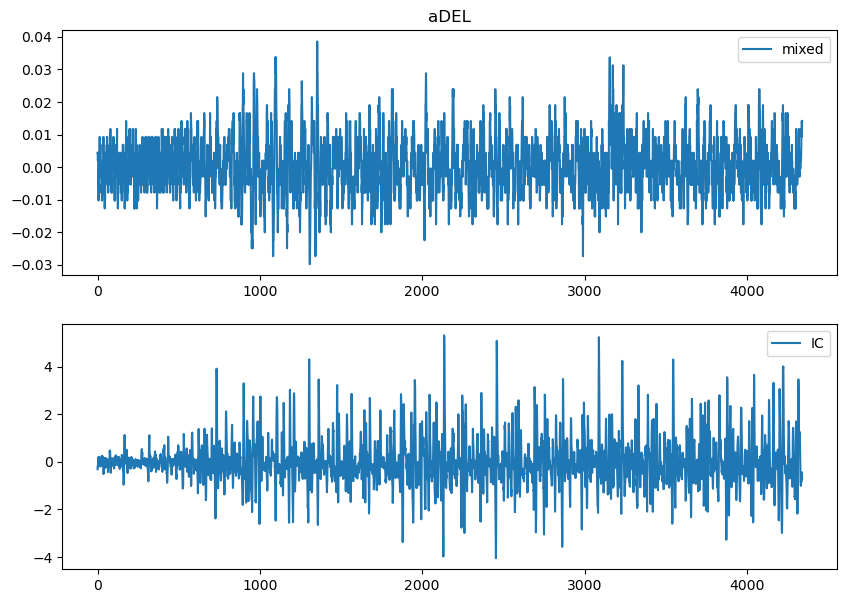

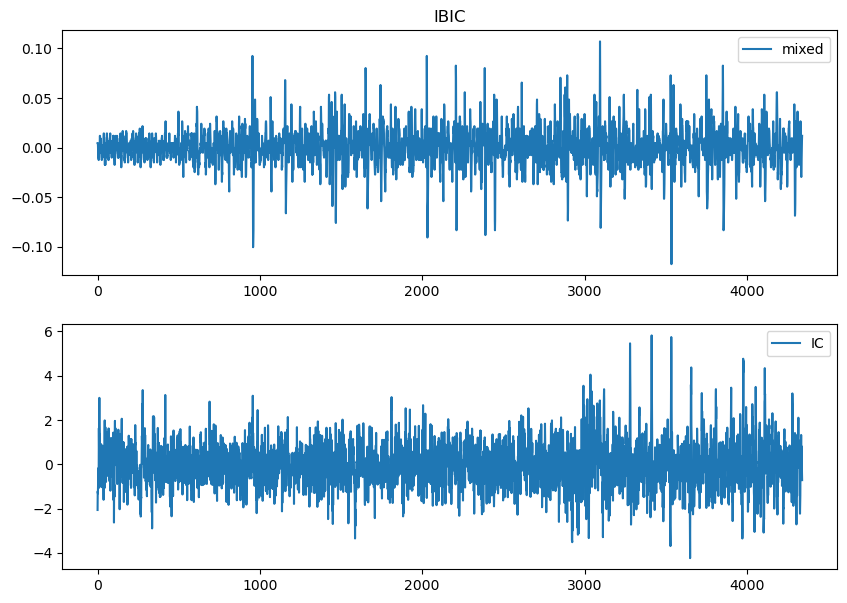

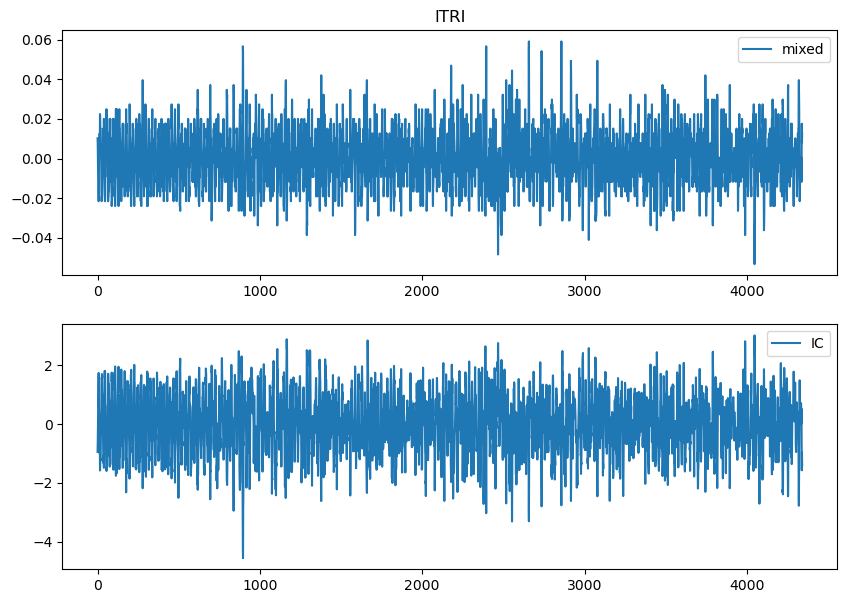

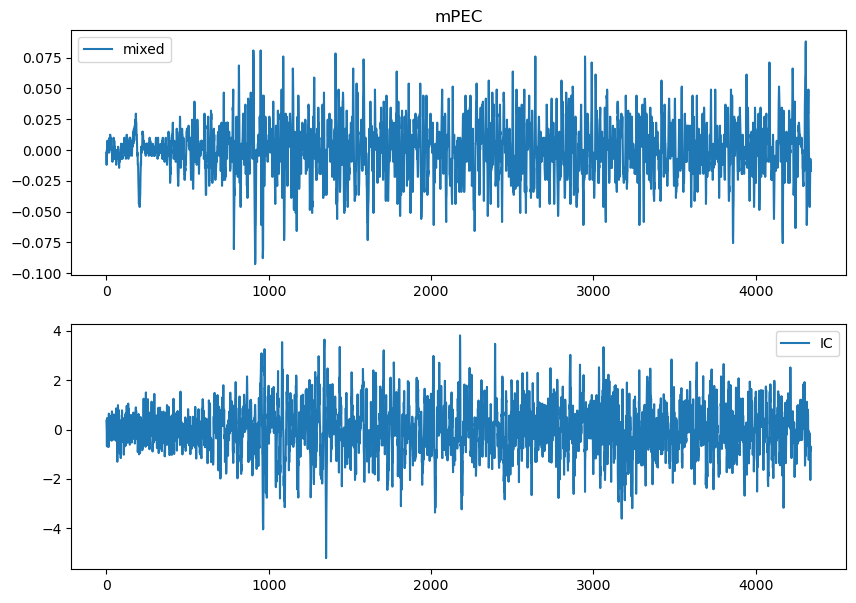

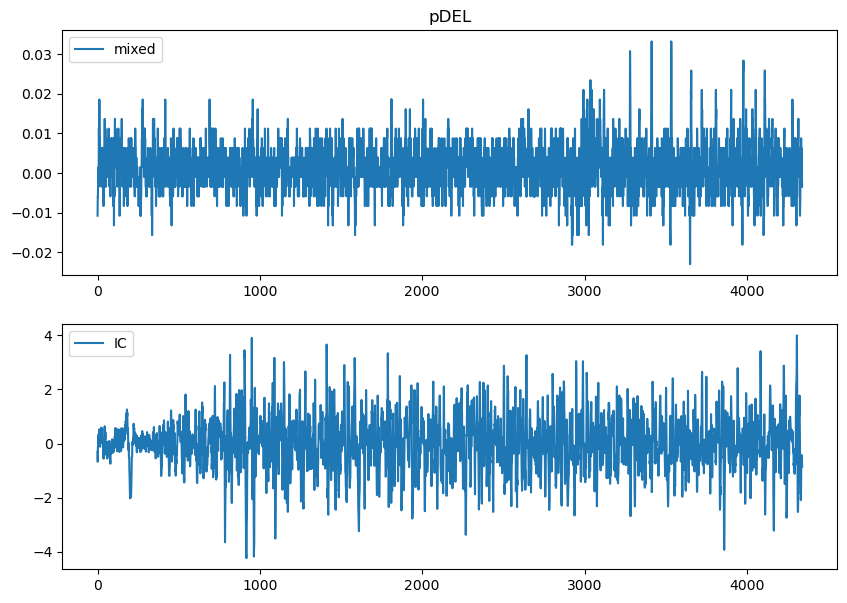

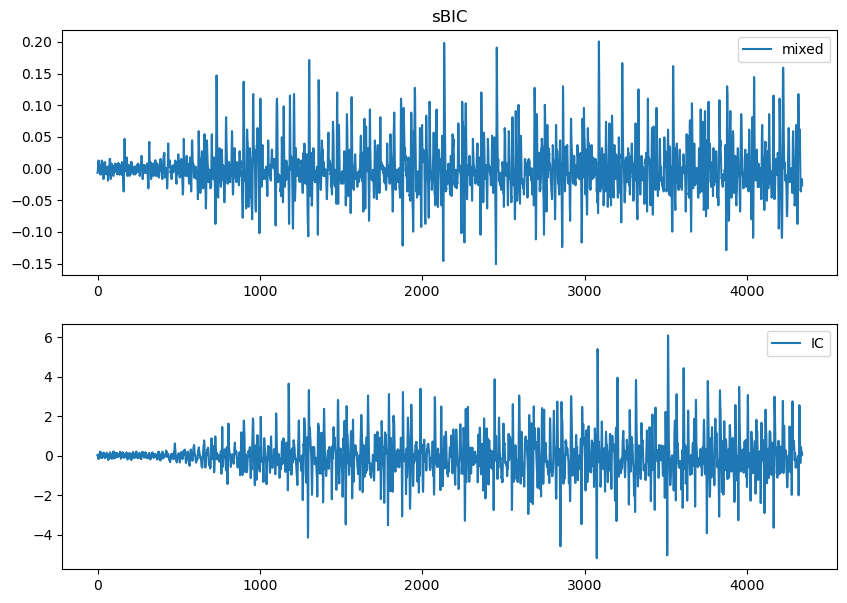

In [12]:
for i in range(len(muscle_fields)):
    plt.figure(figsize=(10,7))
    plt.subplot(2,1,1)
    plt.title(muscle_fields[i])
    plt.plot(X[i,:],label="mixed")
    plt.legend()
    plt.subplot(2,1,2) 
    plt.plot(S_[:,i],label="IC")
    plt.legend()
    plt.show()

In [13]:
data[0][0].keys()

dict_keys(['aDEL', 'pDEL', 'lBIC', 'sBIC', 'lTRI', 'BRA', 'mPEC', 'force_x', 'force_y', 'force_magnitude', 'direction', 'repetition'])

In [14]:
len(data[0][0]['BRA'])

4341

In [15]:
# function to apply ICA
def apply_ICA(data, fields, n_components=7):
    out_data = []
    n_repetitions = len(data[0])
    n_directions = len(data)
    
    for i in range(n_directions):
        out_data.append([])
        for j in range(n_repetitions):
            X = np.array([data[i][j][x] for x in fields])
            ica = FastICA(n_components=n_components)
            S_ = ica.fit_transform(X.T)
            tmp_dict = {}
            for _, x in enumerate(fields):
                tmp_dict[x] = S_[:,_]
            tmp_dict["direction"] = i
            tmp_dict["repetition"] = j
            tmp_dict["force_magnitude"] = data[i][j]["force_magnitude"]
            tmp_dict["force_x"] = data[i][j]["force_x"]
            tmp_dict["force_y"] = data[i][j]["force_y"]
            out_data[i].append(tmp_dict)
            
            
    return out_data
    
ICA_data = apply_ICA(data, muscle_fields)

c:\Users\cribr\miniconda3\envs\biosignal\Lib\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [16]:
ICA_data[0][0].keys()

dict_keys(['BRA', 'aDEL', 'lBIC', 'lTRI', 'mPEC', 'pDEL', 'sBIC', 'direction', 'repetition', 'force_magnitude', 'force_x', 'force_y'])

In [17]:
len(data[0][0]['BRA']), len(ICA_data[0][0]['BRA'])

(4341, 4341)

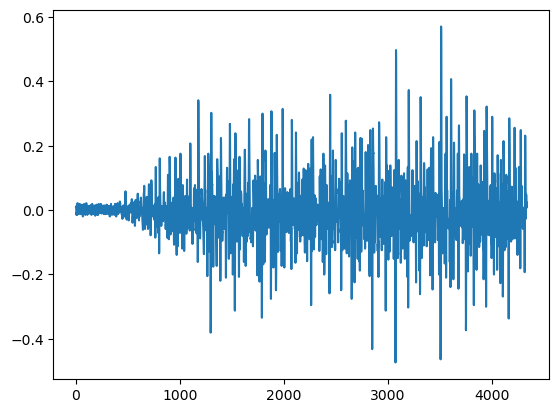

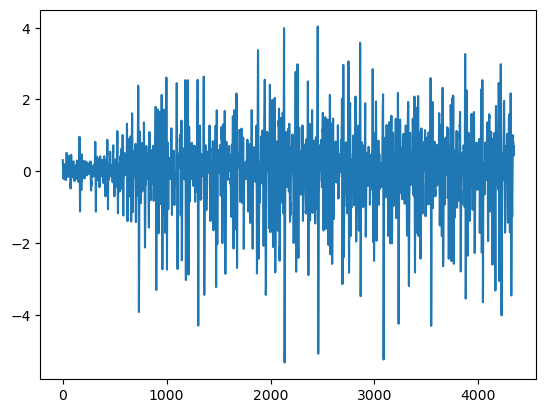

In [18]:
plt.plot(data[0][0]['BRA'])
plt.show()
plt.plot(ICA_data[0][0]['BRA'])
plt.show()

In [19]:
data = ICA_data

## Preprocessing (same as in filtered)

In [20]:
from scipy.ndimage import minimum_filter1d

def estimate_emg_snr_ms(emg, fs, bp_freq=(20, 450), n_fft=512, win_sec=0.025, hop_sec=0.010, min_window_sec=0.5):

    win_len = int(win_sec * fs)
    hop_len = int(hop_sec * fs)
    f, t, Z = stft(
        emg,
        fs=fs,
        nperseg=win_len,
        noverlap=win_len - hop_len,
        nfft=n_fft,
        boundary=None,
    )

    psd = np.abs(Z) ** 2

    min_win = max(1, int(min_window_sec / hop_sec))
    noise_psd = minimum_filter1d(psd, size=min_win, axis=1, mode='reflect')

    band_bins = np.where((f >= bp_freq[0]) & (f <= bp_freq[1]))[0]
    total_power = psd[band_bins].mean(axis=0)
    noise_power = noise_psd[band_bins].mean(axis=0)

    eps = 1e-12
    snr_lin = np.maximum(total_power - noise_power, eps) / np.maximum(noise_power, eps)
    snr_db = 10.0 * np.log10(snr_lin)


    avg_lin = np.mean(snr_lin)
    return 10.0 * np.log10(avg_lin)

In [21]:
avg_snr_pre = []
for trial in np.array(data).flatten():
    for muscle in muscle_fields:
        snr = estimate_emg_snr_ms(trial[muscle], fs=1000, n_fft=64, win_sec=0.05, hop_sec=0.01)
        avg_snr_pre.append(snr)
    
avg_snr_pre = np.mean(avg_snr_pre)
print(f"Average SNR before preprocessing: {avg_snr_pre:.3f}")

Average SNR before preprocessing: 17.807


In [22]:
from copy import deepcopy

def transform_signals(data, func, muscles_to_target=None):
    processed_data = deepcopy(data)
    
    if muscles_to_target is None:
        muscles_to_target = muscle_fields

    for direction in tqdm(range(12)):
        for repetition in range(4):
            for muscle in muscles_to_target:
                current = processed_data[direction][repetition][muscle]
                transformed = func(current)
                processed_data[direction][repetition][muscle] = transformed
    return processed_data

In [23]:
def bandpass_filter(signal, low=20, high=500, fs=1000, order=4):
    nyq_f = fs*0.5
    b, a = butter(order, [low/nyq_f, high/nyq_f], btype="bandpass")
    return filtfilt(b, a, signal)

In [24]:
bandpass_data = transform_signals(data, func=lambda signal: bandpass_filter(signal, low=20, high=450, fs=1000, order=10))

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 27.15it/s]


In [25]:
def notch_filter(signal, notch_freq, fs=1000, Q=30):
    nyq_f = fs*0.5
    w0 = notch_freq / nyq_f
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, signal)

In [26]:
notch_data = transform_signals(bandpass_data, lambda signal: notch_filter(signal, notch_freq=50, fs=1000, Q=30), muscles_to_target=muscle_fields)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 164.39it/s]


In [27]:
avg_snr_ps = []
for trial in np.array(notch_data).flatten():
    for muscle in muscle_fields:
        snr = estimate_emg_snr_ms(trial[muscle], fs=1000, n_fft=64, win_sec=0.05, hop_sec=0.01)
        avg_snr_ps.append(snr)
    
avg_snr_ps = np.mean(avg_snr_ps)
print(f"Average SNR before preprocessing: {avg_snr_pre:.3f}")
print(f"Average SNR after preprocessing: {avg_snr_ps:.3f}")

Average SNR before preprocessing: 17.807
Average SNR after preprocessing: 18.247


In [28]:
rectified_data = transform_signals(notch_data, func=np.abs)

100%|██████████| 12/12 [00:00<00:00, 6001.15it/s]


In [29]:
def lowpass_filter(signal, cutoff=50, fs=1000, order=4):
    nyq_f = fs*0.5
    b, a = butter(order, cutoff/nyq_f, btype="lowpass")
    return filtfilt(b, a, signal)

In [30]:
envelope_data = transform_signals(rectified_data, func=lambda signal: lowpass_filter(signal, cutoff=10, fs=1000, order=4))

100%|██████████| 12/12 [00:00<00:00, 64.63it/s]


In [31]:
downsampled_data = transform_signals(envelope_data, func=lambda signal: scipy.signal.decimate(signal, q=10, ftype='iir', zero_phase=True))

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 24.27it/s]


In [32]:
df_list = [pd.DataFrame(downsampled_data[i][j]) for i in range(12) for j in range(4)]

In [33]:
def plot_signals(ecg, height=1100, width = 1200):
    fig = make_subplots(
    rows=len(muscle_fields), 
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.02,
)

    colors = ['blue', 'red', 'green', 'purple']

    for i, muscle in enumerate(muscle_fields):
        fig.add_trace(
            go.Scatter(
                x=np.arange(len(ecg[muscle])),
                y=ecg[muscle],
                line=dict(width=1, color=colors[i % len(colors)])
            ),
            row=i+1, 
            col=1)

    fig.update_layout(
        width=width,
        height=height,
        title_text=f"EMG Signals",
        showlegend=False
    )

    for i, muscle in enumerate(muscle_fields):
        fig.update_yaxes(title_text=f"{muscle} (mV)", row=i+1, col=1)
        
    fig.show()

In [34]:
df = df_list[0]
plot_signals(df[(df["repetition"]==0) & (df["direction"]==0)][muscle_fields])

In [35]:
df_list[0]

,BRA,aDEL,lBIC,lTRI,mPEC,pDEL,sBIC,direction,repetition,force_magnitude,force_x,force_y
0,0.009135,-0.000561,0.219084,0.010915,0.001705,0.096340,-0.055352,0,0,0.910431,-0.865295,0.283107
1,0.052729,0.026310,0.350384,0.097928,0.076711,0.323526,0.094218,0,0,0.872500,-0.831443,0.264498
2,0.090876,0.045197,0.443429,0.167061,0.138070,0.514886,0.212741,0,0,0.825203,-0.783037,0.260409
3,0.119580,0.055602,0.492486,0.211668,0.178886,0.640749,0.291173,0,0,0.757560,-0.728060,0.209347
4,0.137648,0.059201,0.503719,0.231640,0.198340,0.697226,0.332440,0,0,0.694166,-0.669814,0.182252
...,...,...,...,...,...,...,...,...,...,...,...,...
430,0.699289,0.589302,0.574717,0.971307,0.900687,0.790719,0.548292,0,0,25.307468,-21.572594,-13.232199
431,0.739705,0.580373,0.578811,1.035853,0.973499,0.763007,0.562438,0,0,25.160034,-21.476939,-13.106044
432,0.770232,0.576094,0.587501,1.067753,1.019228,0.741448,0.566144,0,0,25.118052,-21.478387,-13.022883
433,0.785502,0.574565,0.594151,1.077683,1.038752,0.729321,0.564880,0,0,25.061647,-21.398972,-13.044929


In [36]:
merged_df = pd.concat(df_list)
X = merged_df.iloc[:, :-5]
y = merged_df["force_magnitude"]
X.columns

Index(['BRA', 'aDEL', 'lBIC', 'lTRI', 'mPEC', 'pDEL', 'sBIC'], dtype='object')

### Regression Task

#### Raw signals predicting magnitude

In [37]:
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

In [38]:
df_trval, df_te, y_trval, y_te = train_test_split(merged_df, y, test_size=0.2)
X_trval, X_te = df_trval.iloc[:, :-5], df_te.iloc[:, :-5]
print(X_te.columns.tolist())
X_trval.shape, X_te.shape, y_trval.shape, y_te.shape

['BRA', 'aDEL', 'lBIC', 'lTRI', 'mPEC', 'pDEL', 'sBIC']


((16389, 7), (4098, 7), (16389,), (4098,))

In [39]:
folds = [(tr_idxs, val_idxs) for tr_idxs, val_idxs in GroupKFold(4).split(X_trval, y_trval, groups=df_trval["repetition"])]

In [40]:
for d in range(1, 6):
    d_rmse = 0
    d_r2 = 0
    for i, (tr_idxs, val_idxs) in enumerate(folds):
        X_tr, X_val = X_trval.iloc[tr_idxs], X_trval.iloc[val_idxs]
        y_tr, y_val = y_trval.iloc[tr_idxs], y_trval.iloc[val_idxs]

        scaler = StandardScaler()
        scaler.fit(X_tr)
        X_tr = pd.DataFrame(scaler.transform(X_tr), columns=scaler.get_feature_names_out())
        X_val = pd.DataFrame(scaler.transform(X_val), columns=scaler.get_feature_names_out())
        
        poly = PolynomialFeatures(degree=d, include_bias=False)
        X_tr_poly = poly.fit_transform(X_tr)
        X_val_poly = poly.transform(X_val)
        
        lr = LinearRegression().fit(X_tr_poly, y_tr) 
        tr_preds = lr.predict(X_tr_poly)
        y_preds = lr.predict(X_val_poly)
        fold_rmse = root_mean_squared_error(y_val, y_preds)
        fold_r2 = r2_score(y_val, y_preds)
        print(f"Degree {d} - fold {i+1}   |   Train RMSE: {root_mean_squared_error(y_tr, tr_preds)}   |   Train R^2: {r2_score(tr_preds, y_tr)}   |   Valid RMSE: {fold_rmse}   |   Valid R^2: {fold_r2}")
        d_rmse+=fold_rmse
        d_r2+=fold_r2
    d_rmse /= len(folds)
    d_r2 /= len(folds)
    print(f"\nd={d} Mean Valid RMSE: {d_rmse}   |   Mean Valid R^2: {d_r2}")
    print("\n\n")

Degree 1 - fold 1   |   Train RMSE: 4.464394806120745   |   Train R^2: 0.6221956735632932   |   Valid RMSE: 4.46252827529074   |   Valid R^2: 0.7008523436779377
Degree 1 - fold 2   |   Train RMSE: 4.465583500432212   |   Train R^2: 0.5975445358783895   |   Valid RMSE: 4.438099442016636   |   Valid R^2: 0.739324848798901
Degree 1 - fold 3   |   Train RMSE: 4.423460481537594   |   Train R^2: 0.6183102985109779   |   Valid RMSE: 4.571098451342841   |   Valid R^2: 0.7079398499009616
Degree 1 - fold 4   |   Train RMSE: 4.425103238759166   |   Train R^2: 0.6195956359174051   |   Valid RMSE: 4.559997510035417   |   Valid R^2: 0.7061504491625172

d=1 Mean Valid RMSE: 4.507930919671408   |   Mean Valid R^2: 0.7135668728850795



Degree 2 - fold 1   |   Train RMSE: 3.589101838382672   |   Train R^2: 0.7846004279357532   |   Valid RMSE: 4.024714011222682   |   Valid R^2: 0.7566710992421297
Degree 2 - fold 2   |   Train RMSE: 3.6906684945961215   |   Train R^2: 0.7562005261222312   |   Valid RMSE:

In [41]:
# visualizing best (3 degree) results
df_trval, df_te, y_trval, y_te = train_test_split(merged_df, y, test_size=0.2)
X_trval, X_te = df_trval.iloc[:, :-5], df_te.iloc[:, :-5]

scaler = StandardScaler()
scaler.fit(X_trval)
X_tr = pd.DataFrame(scaler.transform(X_trval), columns=scaler.get_feature_names_out())
X_te = pd.DataFrame(scaler.transform(X_te), columns=scaler.get_feature_names_out())

poly = PolynomialFeatures(degree=d, include_bias=False)
X_tr_poly = poly.fit_transform(X_tr)
X_te_poly = poly.transform(X_te)

lr = LinearRegression().fit(X_tr_poly, y_trval) 
tr_preds = lr.predict(X_tr_poly)
te_preds = lr.predict(X_te_poly)

tr_r2 = r2_score(tr_preds, y_trval)
te_r2 = r2_score(te_preds, y_te)

print("Train R2: ", tr_r2)
print("Test R2: ", te_r2)

Train R2:  0.9014473531550586
Test R2:  0.887289569629261


In [42]:
X_tr.iloc[:10,0]

0    1.378117
1   -0.936001
2    1.090771
3    0.987800
4    0.343558
5    0.021297
6   -0.360863
7   -1.189865
8    0.737932
9    0.163455
Name: BRA, dtype: float64

Text(0, 0.5, 'force magnitude')

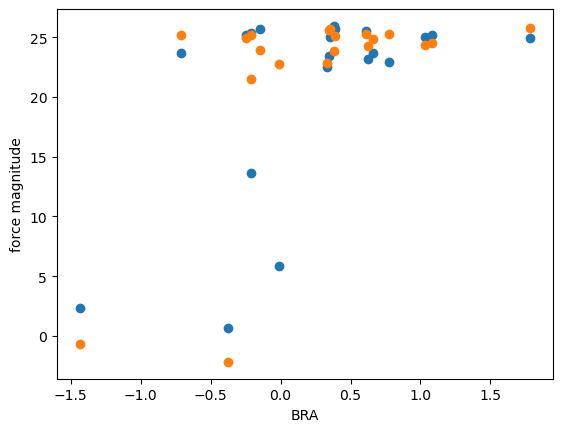

In [43]:
n = 20
x_feature_idx = 0
plt.scatter(x=X_te.iloc[:n,x_feature_idx], y=y_te[:n])
plt.scatter(x=X_te.iloc[:n,x_feature_idx], y=te_preds[:n])
plt.xlabel(X_te.columns[x_feature_idx])
plt.ylabel("force magnitude")

In [44]:
df_list[13]

,BRA,aDEL,lBIC,lTRI,mPEC,pDEL,sBIC,direction,repetition,force_magnitude,force_x,force_y
0,0.053914,0.121871,0.133220,0.381934,-0.033514,0.247933,0.125993,3,1,1.908887,1.083161,-1.571819
1,0.087842,0.388982,0.279368,0.390308,0.088131,0.323035,0.191737,3,1,1.886170,1.149503,-1.495419
2,0.119649,0.651485,0.441946,0.386394,0.181773,0.398066,0.234510,3,1,1.908538,1.068059,-1.581697
3,0.141932,0.877761,0.605276,0.370125,0.239560,0.464617,0.247826,3,1,1.887851,1.024005,-1.586000
4,0.151159,1.051136,0.751775,0.347958,0.264983,0.519786,0.238436,3,1,1.881351,1.048946,-1.561792
...,...,...,...,...,...,...,...,...,...,...,...,...
460,0.529878,0.420453,0.491721,0.632560,0.977162,0.557163,0.482984,3,1,25.071758,13.048829,-21.408436
461,0.531681,0.421411,0.543800,0.601437,1.012299,0.551062,0.481382,3,1,25.100086,13.072326,-21.427286
462,0.540690,0.420537,0.584575,0.577457,1.027544,0.548465,0.489648,3,1,25.167094,13.166174,-21.448414
463,0.548592,0.419333,0.606382,0.564529,1.030638,0.547449,0.497704,3,1,25.227997,13.237300,-21.476166


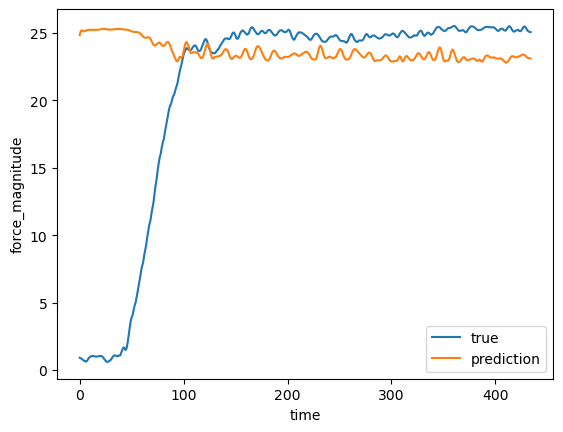

In [45]:
# predicting for one repetition and one direction
direction = 0 # [0,11]
repetition = 0 # [0,3]

df_direction = merged_df[merged_df["direction"] == direction]
df_repetition = df_direction[df_direction["repetition"] == repetition]

X = df_repetition.iloc[:,:-5]
y = df_repetition["force_magnitude"]

X_poly = poly.fit_transform(X)
pred = lr.predict(X_poly)

plt.plot(y, label="true")
plt.plot(pred, label="prediction")
plt.xlabel("time")
plt.ylabel("force_magnitude")
plt.legend()

By visualizing the plots of the various trials we can notice that the r2 squared is not a good indicator of performances
since the polynomial regressor predict always around 25 Newton of force, that is the maximum force that the subject has
to enforce to maintain an isometric condition during the experiment.

### Regressors for x_force and y_force

In [46]:
y = merged_df[["force_x", "force_y"]]
df_trval, df_te, y_trval, y_te = train_test_split(merged_df, y, test_size=0.2)
X_trval, X_te = df_trval.iloc[:, :-5], df_te.iloc[:, :-5]


folds = [(tr_idxs, val_idxs) for tr_idxs, val_idxs in GroupKFold(4).split(X_trval, y_trval, groups=df_trval["repetition"])]


for d in range(1, 6):
    d_rmse_x = 0
    d_r2_x = 0
    d_rmse_y = 0
    d_r2_y = 0
    for i, (tr_idxs, val_idxs) in enumerate(folds):
        X_tr, X_val = X_trval.iloc[tr_idxs], X_trval.iloc[val_idxs]
        y_tr, y_val = y_trval.iloc[tr_idxs], y_trval.iloc[val_idxs]

        scaler = StandardScaler()
        scaler.fit(X_tr)
        X_tr = pd.DataFrame(scaler.transform(X_tr), columns=scaler.get_feature_names_out())
        X_val = pd.DataFrame(scaler.transform(X_val), columns=scaler.get_feature_names_out())
        
        poly = PolynomialFeatures(degree=d, include_bias=False)
        X_tr_poly = poly.fit_transform(X_tr)
        X_val_poly = poly.transform(X_val)
        
        # x regressor
        lr_x = LinearRegression().fit(X_tr_poly, y_tr["force_x"]) 
        tr_preds = lr_x.predict(X_tr_poly)
        y_preds = lr_x.predict(X_val_poly)
        fold_rmse_x = root_mean_squared_error(y_val["force_x"], y_preds)
        fold_r2_x = r2_score(y_val["force_x"], y_preds)
        print(f"Degree {d} - fold {i+1}   |   Train RMSE: {root_mean_squared_error(y_tr['force_x'], tr_preds)}   |   Train R^2: {r2_score(tr_preds, y_tr['force_x'])}   |   Valid RMSE: {fold_rmse_x}   |   Valid R^2: {fold_r2_x}")
        d_rmse_x+=fold_rmse_x
        d_r2_x+=fold_r2_x
        
        # y regressor
        lr_y = LinearRegression().fit(X_tr_poly, y_tr["force_y"]) 
        tr_preds = lr_y.predict(X_tr_poly)
        y_preds = lr_y.predict(X_val_poly)
        fold_rmse_y = root_mean_squared_error(y_val["force_y"], y_preds)
        fold_r2_y = r2_score(y_val["force_y"], y_preds)
        print(f"Degree {d} - fold {i+1}   |   Train RMSE: {root_mean_squared_error(y_tr['force_y'], tr_preds)}   |   Train R^2: {r2_score(tr_preds, y_tr['force_y'])}   |   Valid RMSE: {fold_rmse_y}   |   Valid R^2: {fold_r2_y}")
        d_rmse_y+=fold_rmse_y
        d_r2_y+=fold_r2_y
        
        
    d_rmse_x /= len(folds)
    d_r2_x /= len(folds)
    d_rmse_y /= len(folds)
    d_r2_y /= len(folds)
    print(f"\nd={d}, x, Mean Valid RMSE: {d_rmse_x}   |   Mean Valid R^2: {d_r2_x}")
    print(f"\nd={d}, y, Mean Valid RMSE: {d_rmse_y}   |   Mean Valid R^2: {d_r2_y}")
    print("\n\n")

Degree 1 - fold 1   |   Train RMSE: 15.706537866683366   |   Train R^2: -91.17076012134481   |   Valid RMSE: 15.39710155137723   |   Valid R^2: 0.0010131042023198145
Degree 1 - fold 1   |   Train RMSE: 15.56376535699938   |   Train R^2: -41.241097508602884   |   Valid RMSE: 15.893857635824695   |   Valid R^2: -0.028004116699072767
Degree 1 - fold 2   |   Train RMSE: 15.606997837123693   |   Train R^2: -91.67080923469634   |   Valid RMSE: 15.694270434930479   |   Valid R^2: -0.0015744343019081786
Degree 1 - fold 2   |   Train RMSE: 15.390500891671124   |   Train R^2: -20.438400321522654   |   Valid RMSE: 15.76006028361036   |   Valid R^2: -0.011300651211048507
Degree 1 - fold 3   |   Train RMSE: 15.168859115583276   |   Train R^2: -13.934844726384533   |   Valid RMSE: 17.73359581259049   |   Valid R^2: -0.26683700070383365
Degree 1 - fold 3   |   Train RMSE: 15.232377519101757   |   Train R^2: -14.940350746754419   |   Valid RMSE: 16.34299066685101   |   Valid R^2: -0.06789977725482554


In [47]:
# visualizing best (5 degree) results
degree = 5

df_trval, df_te, y_trval, y_te = train_test_split(merged_df, y, test_size=0.2)
X_trval, X_te = df_trval.iloc[:, :-5], df_te.iloc[:, :-5]

scaler = StandardScaler()
scaler.fit(X_trval)
X_tr = pd.DataFrame(scaler.transform(X_trval), columns=scaler.get_feature_names_out())
X_te = pd.DataFrame(scaler.transform(X_te), columns=scaler.get_feature_names_out())

poly = PolynomialFeatures(degree=degree, include_bias=False)
X_tr_poly = poly.fit_transform(X_tr)
X_te_poly = poly.transform(X_te)

lr_x = LinearRegression().fit(X_tr_poly, y_trval["force_x"]) 
tr_preds = lr_x.predict(X_tr_poly)
te_preds = lr_x.predict(X_te_poly)

tr_r2_x = r2_score(tr_preds, y_trval["force_x"])
te_r2_x = r2_score(te_preds, y_te["force_x"])

print("X, Train R2: ", tr_r2_x)
print("X, Test R2: ", te_r2_x)

lr_y = LinearRegression().fit(X_tr_poly, y_trval["force_y"]) 
tr_preds = lr_y.predict(X_tr_poly)
te_preds = lr_y.predict(X_te_poly)

tr_r2_y = r2_score(tr_preds, y_trval["force_y"])
te_r2_y = r2_score(te_preds, y_te["force_y"])

print("X, Train R2: ", tr_r2_y)
print("X, Test R2: ", te_r2_y)

X, Train R2:  -1.79214741215795
X, Test R2:  -0.2870789030155467
X, Train R2:  -1.2309602231898986
X, Test R2:  -1.1799974942678046


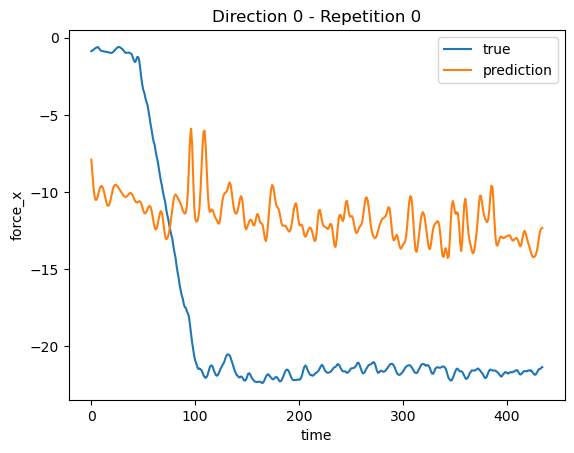

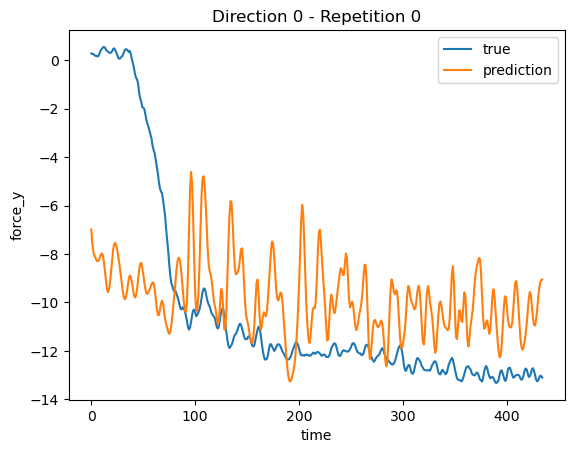

In [48]:
# predicting for one repetition and one direction
direction = 0# [0,11]
repetition = 0 # [0,3]

df_direction = merged_df[merged_df["direction"] == direction]
df_repetition = df_direction[df_direction["repetition"] == repetition]

X = df_repetition.iloc[:,:-5]
y_x = df_repetition["force_x"]
y_y = df_repetition["force_y"]

X_poly = poly.fit_transform(X)
pred_x = lr_x.predict(X_poly)
pred_y = lr_y.predict(X_poly)

plt.title(f"Direction {direction} - Repetition {repetition}")
plt.plot(y_x, label="true")
plt.plot(pred_x, label="prediction")
plt.xlabel("time")
plt.ylabel("force_x")
plt.legend()
plt.show()

plt.title(f"Direction {direction} - Repetition {repetition}")
plt.plot(y_y, label="true")
plt.plot(pred_y, label="prediction")
plt.xlabel("time")
plt.ylabel("force_y")
plt.legend()
plt.show()